In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class VanillaGAN:
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim
        self.img_shape = (28, 28, 1)
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            optimizer=keras.optimizers.Adam(0.0002, 0.5),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Build the generator
        self.generator = self.build_generator()
        
        # Build the combined model (generator + discriminator)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        # The generator takes noise as input and generates images
        z = keras.Input(shape=(self.latent_dim,))
        img = self.generator(z)
        
        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)
        
        # The combined model (stacked generator and discriminator)
        self.combined = keras.Model(z, validity)
        self.combined.compile(
            optimizer=keras.optimizers.Adam(0.0002, 0.5),
            loss='binary_crossentropy'
        )
    
    def build_generator(self):
        """Build the generator network"""
        model = keras.Sequential([
            layers.Dense(256, input_dim=self.latent_dim),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(momentum=0.8),
            
            layers.Dense(512),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(momentum=0.8),
            
            layers.Dense(1024),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(momentum=0.8),
            
            layers.Dense(np.prod(self.img_shape), activation='tanh'),
            layers.Reshape(self.img_shape)
        ])
        
        noise = keras.Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return keras.Model(noise, img, name="Generator")
    
    def build_discriminator(self):
        """Build the discriminator network"""
        model = keras.Sequential([
            layers.Flatten(input_shape=self.img_shape),
            
            layers.Dense(512),
            layers.LeakyReLU(alpha=0.2),
            
            layers.Dense(256),
            layers.LeakyReLU(alpha=0.2),
            
            layers.Dense(1, activation='sigmoid')
        ])
        
        img = keras.Input(shape=self.img_shape)
        validity = model(img)
        
        return keras.Model(img, validity, name="Discriminator")
    
    def load_data(self):
        """Load and preprocess the MNIST dataset"""
        # Load the MNIST dataset
        (X_train, _), (_, _) = keras.datasets.mnist.load_data()
        
        # Rescale -1 to 1 (for tanh activation in generator)
        X_train = X_train / 127.5 - 1.0
        X_train = np.expand_dims(X_train, axis=3)
        
        return X_train
    
    def sample_images(self, epoch, save_path=None):
        """Generate and save sample images"""
        r, c = 4, 4
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise, verbose=0)
        
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c, figsize=(8, 8))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        
        if save_path:
            fig.savefig(f"{save_path}/mnist_{epoch}.png")
        plt.show()
        plt.close()
    
    def train(self, epochs, batch_size=32, sample_interval=50):
        """Train the GAN"""
        # Load the dataset
        X_train = self.load_data()
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Training history
        d_losses = []
        g_losses = []
        
        for epoch in range(epochs):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise, verbose=0)
            
            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            #  Train Generator
            # ---------------------
            
            # Train the generator (wants discriminator to mistake images as real)
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)
            
            # Store losses
            d_losses.append(d_loss[0])
            g_losses.append(g_loss)
            
            # Print the progress
            if epoch % 100 == 0:
                print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
            
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
        
        # Plot training losses
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(d_losses, label='Discriminator Loss')
        plt.plot(g_losses, label='Generator Loss')
        plt.title('Training Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot([100*acc for _, acc in zip(d_losses, [0.5]*len(d_losses))], label='Discriminator Accuracy')
        plt.title('Discriminator Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

Generator Architecture:


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28, 1)      │     1,493,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)


Discriminator Architecture:


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1)              │       533,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 533,505 (2.04 MB)


Starting training...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 14s 1us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.6657, acc.: 50.78%] [G loss: 0.6984]


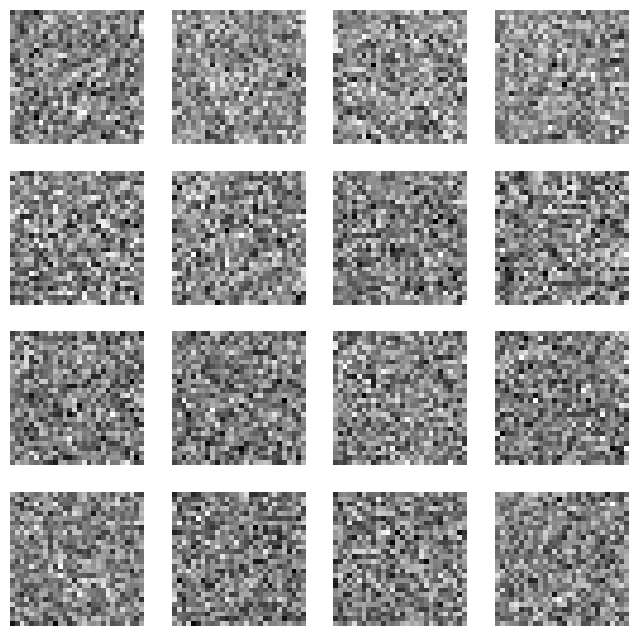

100 [D loss: 1.4044, acc.: 38.23%] [G loss: 0.1854]
200 [D loss: 1.8361, acc.: 37.33%] [G loss: 0.1052]
300 [D loss: 2.1194, acc.: 37.20%] [G loss: 0.0737]
400 [D loss: 2.3227, acc.: 37.13%] [G loss: 0.0568]
500 [D loss: 2.4824, acc.: 37.25%] [G loss: 0.0463]


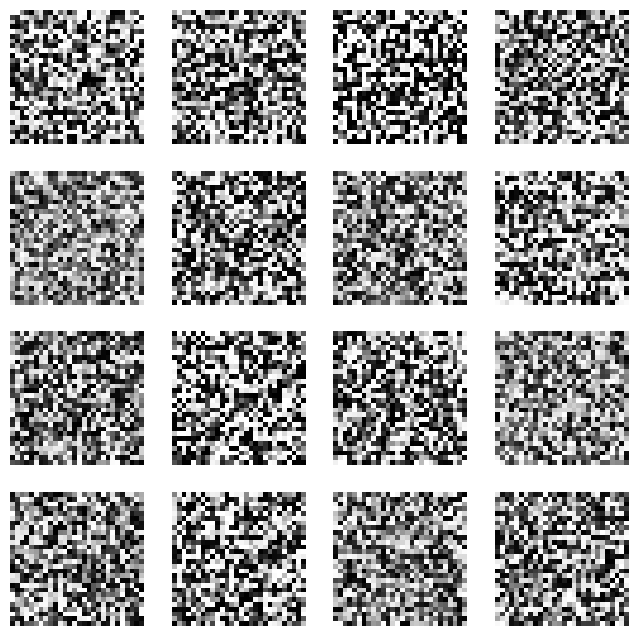

600 [D loss: 2.6164, acc.: 37.24%] [G loss: 0.0391]
700 [D loss: 2.7281, acc.: 37.24%] [G loss: 0.0339]
800 [D loss: 2.8269, acc.: 37.16%] [G loss: 0.0299]
900 [D loss: 2.9113, acc.: 37.18%] [G loss: 0.0267]
1000 [D loss: 2.9889, acc.: 37.16%] [G loss: 0.0242]


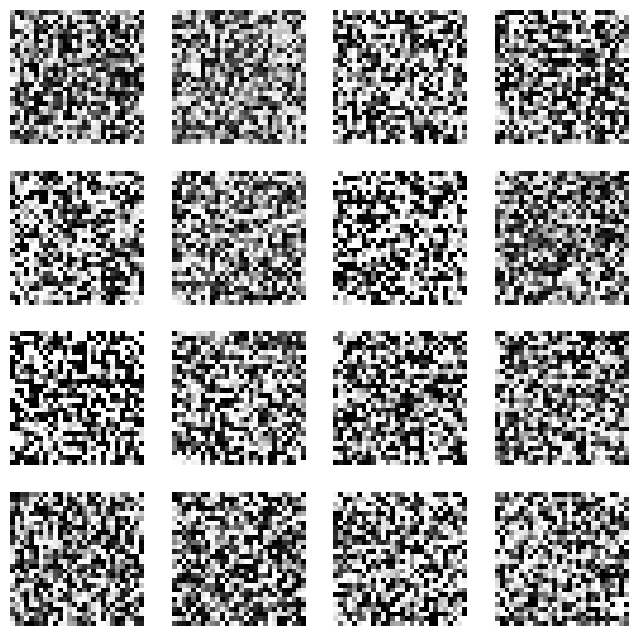

1100 [D loss: 3.0589, acc.: 37.12%] [G loss: 0.0221]
1200 [D loss: 3.1234, acc.: 37.13%] [G loss: 0.0203]
1300 [D loss: 3.1825, acc.: 37.14%] [G loss: 0.0188]
1400 [D loss: 3.2370, acc.: 37.11%] [G loss: 0.0175]
1500 [D loss: 3.2885, acc.: 37.09%] [G loss: 0.0164]


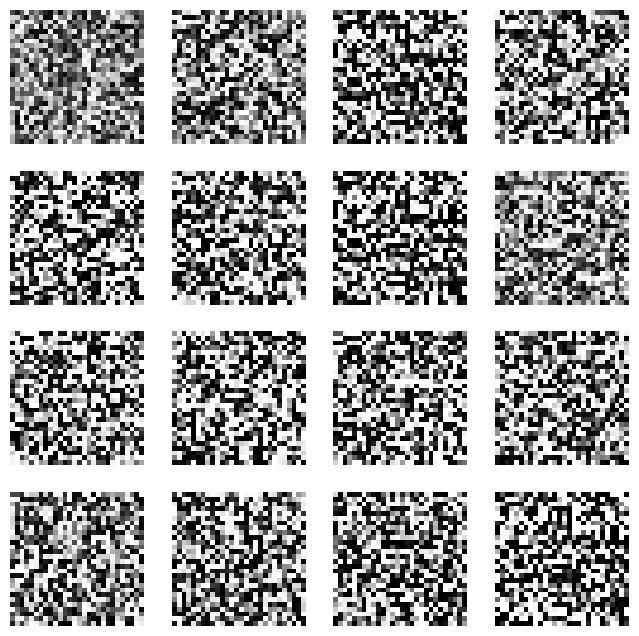

1600 [D loss: 3.3361, acc.: 37.07%] [G loss: 0.0154]
1700 [D loss: 3.3808, acc.: 37.09%] [G loss: 0.0146]
1800 [D loss: 3.4228, acc.: 37.07%] [G loss: 0.0138]
1900 [D loss: 3.4623, acc.: 37.06%] [G loss: 0.0131]
2000 [D loss: 3.5015, acc.: 37.05%] [G loss: 0.0124]


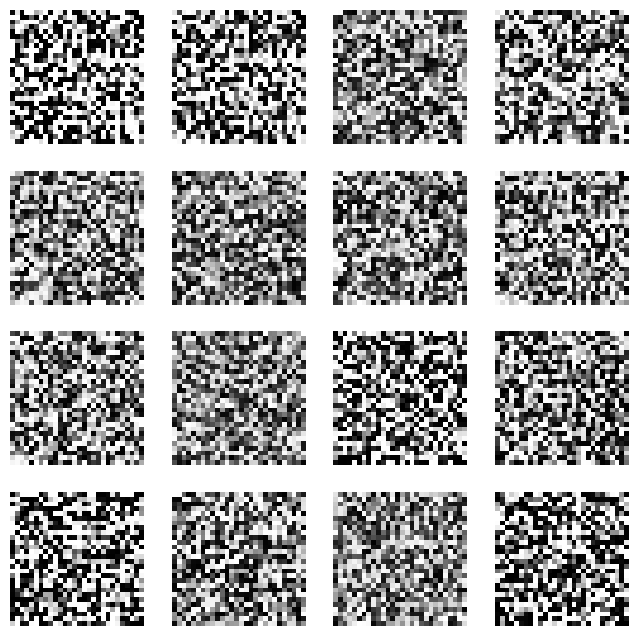

2100 [D loss: 3.5374, acc.: 37.06%] [G loss: 0.0119]
2200 [D loss: 3.5720, acc.: 37.06%] [G loss: 0.0113]
2300 [D loss: 3.6058, acc.: 37.04%] [G loss: 0.0109]
2400 [D loss: 3.6384, acc.: 37.06%] [G loss: 0.0104]
2500 [D loss: 3.6693, acc.: 37.08%] [G loss: 0.0100]


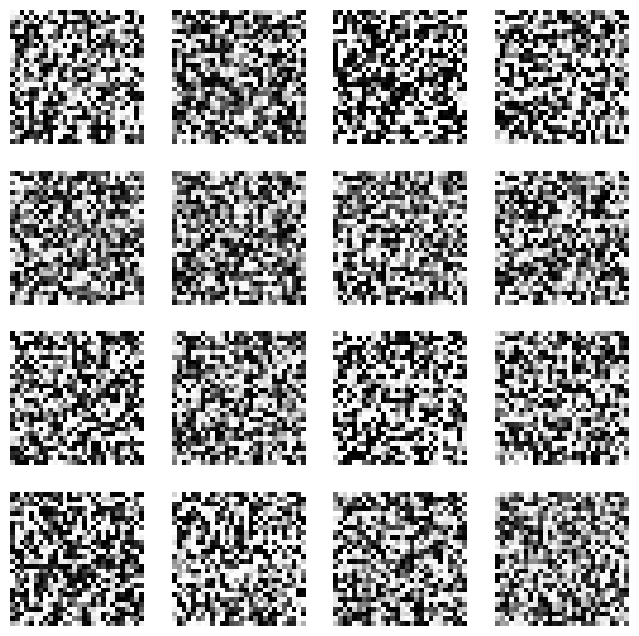

2600 [D loss: 3.6991, acc.: 37.08%] [G loss: 0.0096]
2700 [D loss: 3.7284, acc.: 37.09%] [G loss: 0.0093]
2800 [D loss: 3.7569, acc.: 37.08%] [G loss: 0.0090]
2900 [D loss: 3.7834, acc.: 37.08%] [G loss: 0.0087]
3000 [D loss: 3.8101, acc.: 37.08%] [G loss: 0.0084]


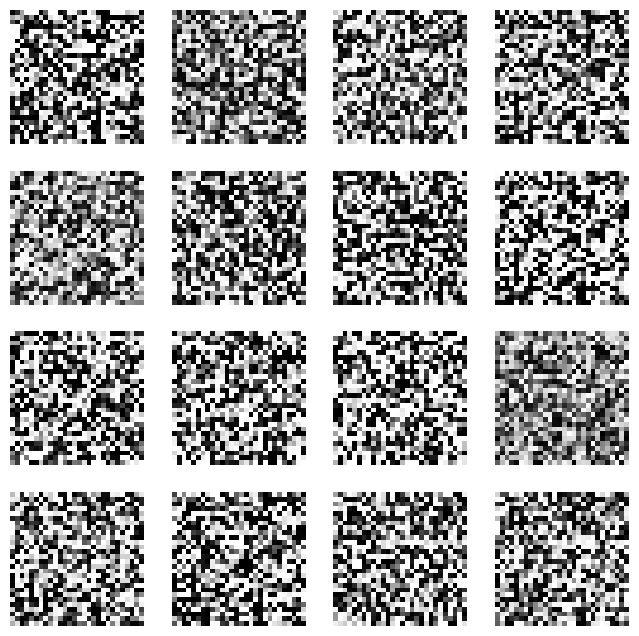

3100 [D loss: 3.8361, acc.: 37.11%] [G loss: 0.0081]
3200 [D loss: 3.8611, acc.: 37.11%] [G loss: 0.0079]
3300 [D loss: 3.8849, acc.: 37.10%] [G loss: 0.0076]
3400 [D loss: 3.9086, acc.: 37.11%] [G loss: 0.0074]
3500 [D loss: 3.9318, acc.: 37.12%] [G loss: 0.0072]


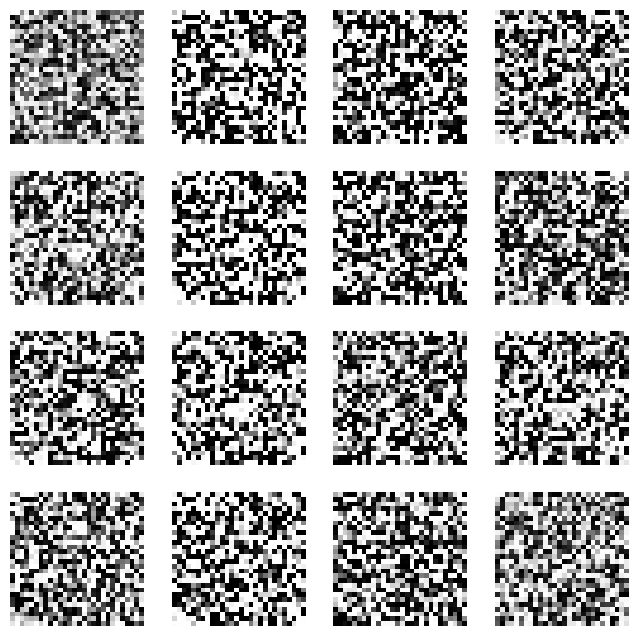

3600 [D loss: 3.9547, acc.: 37.11%] [G loss: 0.0070]
3700 [D loss: 3.9769, acc.: 37.11%] [G loss: 0.0068]
3800 [D loss: 3.9991, acc.: 37.10%] [G loss: 0.0067]
3900 [D loss: 4.0205, acc.: 37.09%] [G loss: 0.0065]


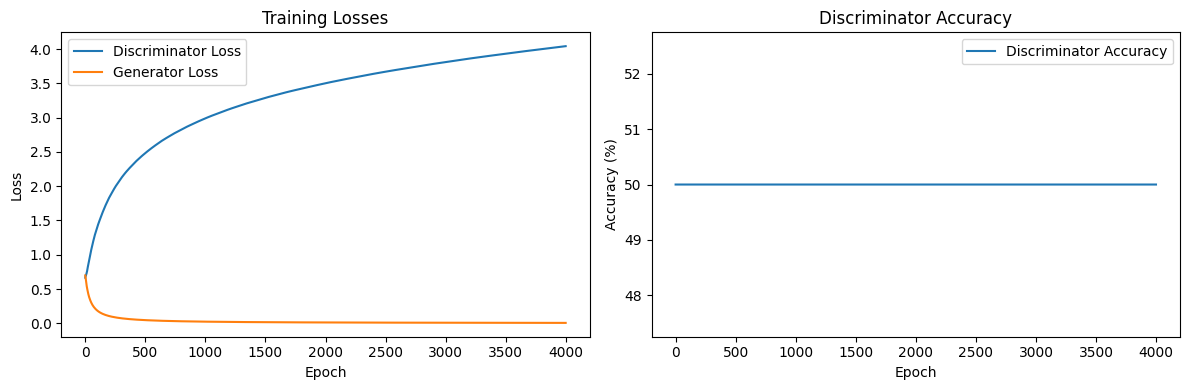


Generating final samples...


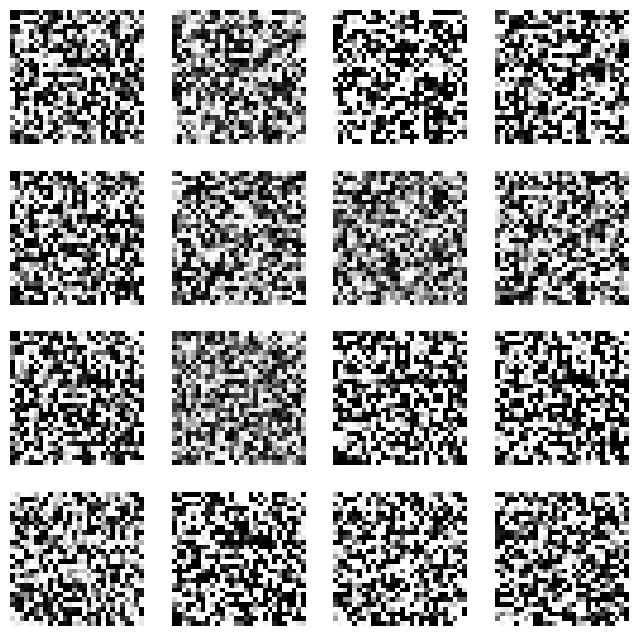

In [3]:
# Example usage
if __name__ == "__main__":
    # Create GAN instance
    gan = VanillaGAN(latent_dim=100)
    
    # Print model summaries
    print("Generator Architecture:")
    gan.generator.summary()
    print("\nDiscriminator Architecture:")
    gan.discriminator.summary()
    
    # Train the GAN
    print("\nStarting training...")
    gan.train(epochs=4000, batch_size=32, sample_interval=500)
    
    # Generate final samples
    print("\nGenerating final samples...")
    gan.sample_images("final")